# Deep Neural Rejection

In this tutorial we show how to train and evaluate DNR (Deep Neural Rejection),
a reject-based defense against adversarial examples. For more details please refer to:

  > [[sotgiu20]](https://arxiv.org/pdf/1910.00470.pdf)
  > Sotgiu, A., Demontis, A., Melis, M., Biggio, B., Fumera, G., Feng, X., Roli, F.,
  > "Deep neural rejection against adversarial examples",
  > EURASIP J. on Info. Security 2020, 5 (2020).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/12-DNR.ipynb)

<div class="alert alert-warning">

**Warning**

Requires installation of the `pytorch` extra dependency.
See [extra components](../index.rst#extra-components) for more information.

</div>

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

%pip install git+https://gitlab.com/secml/secml#egg=secml[pytorch]

DNR analyzes the representations of input samples at different network layers,
and rejects samples which exhibit anomalous behavior with respect to that
observed from the training data at such layers.

As explained in our paper, we trained SVM classifiers with RBF kernel on each
layer in order to exploit the CAP (Compact Abating Probability) property, i.e.
assigned class scores decrease as samples move away from training data
distributions. The outputs of these SVMs are then combined using another RBF
SVM, which will provide prediction scores for each class. This classifier will
reject samples if the maximum class score is not higher than the rejection
threshold. We consider rejection as an additional class.

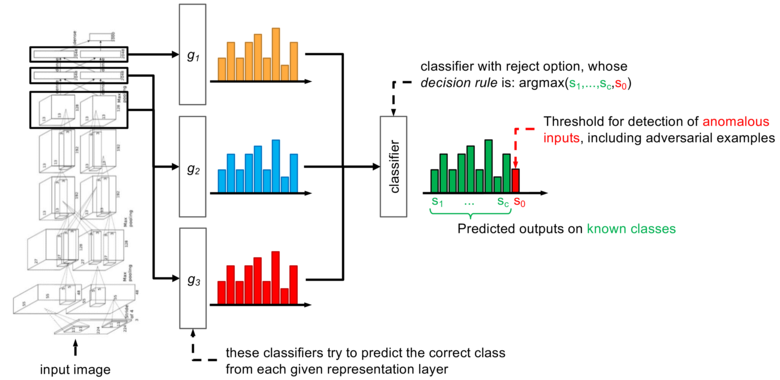

In [2]:
from IPython.display import display, Image
display(Image(filename='_images/dnr.png'))

## Dataset creation

In this notebook we will use the **MNIST handwritten digit dataset**.

In our experiments we follow these steps for the training phase:
1. we split the MNIST training set into two parts;
2. we train a CNN on the first half of the training set;
3. we randomly subsample 1000 samples per class from the second half of the
training set, and use them to train DNR.

To save time, a CNN pre-trained on the first half of MNIST training set
can be downloaded from our model zoo,
and we use 5000 samples (instead of 10,000 samples) 
from the second half of the training set to train DNR.

In [3]:
from secml.array import CArray
from secml.data.loader import CDataLoaderMNIST
from secml.data.selection import CPSRandom
from secml.data.splitter import CDataSplitterShuffle

# load MNIST training set and divide it in two parts
tr_data = CDataLoaderMNIST().load(ds='training')
tr_data.X /= 255.0
splitter = CDataSplitterShuffle(num_folds=1, train_size=0.5,
                                test_size=0.5, random_state=1)
splitter.compute_indices(tr_data)

# dnr training set, reduced to 5000 random samples
tr_set = tr_data[splitter.tr_idx[0], :]
tr_set = CPSRandom().select(dataset=tr_set, n_prototypes=5000, random_state=0)

# load test set
ts_set = CDataLoaderMNIST().load(ds='testing', num_samples=1000)
ts_set.X /= 255.0

In [4]:
# NBVAL_IGNORE_OUTPUT
from secml.model_zoo import load_model
# load from model zoo the pre-trained net
dnn = load_model("mnist-cnn")

## Training DNR

We now set up and fit the DNR classifier. The `CClassifierDNR` class can work
with any multiclass classifier as combiner and layer classifiers. We will use
RBF SVM for the aforementioned reason.

We have chosen the last three ReLu layers of the CNN. To save time, here we
manually set the same SVM parameters we found with cross-validation in our
paper. Note that parameters of layer classifiers can be set with `CCreator`
utilities. Each layer classifier can be accessed using the name of the layer on
it works.

Finally, `CClassifierDNR` provides a method to compute the reject threshold on
a validation set, based on the desired rejection rate.

In [5]:
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF
from secml.ml.classifiers.reject import CClassifierDNR

layers = ['features:relu2', 'features:relu3', 'features:relu4']
combiner = CClassifierSVM(kernel=CKernelRBF(gamma=1), C=0.1)
layer_clf = CClassifierSVM(kernel=CKernelRBF(gamma=1e-2), C=10)

dnr = CClassifierDNR(combiner=combiner, layer_clf=layer_clf, dnn=dnn,
                     layers=layers, threshold=-1000)
dnr.set_params({'features:relu4.C': 1, 'features:relu2.kernel.gamma': 1e-3})

print("Training started...")
dnr.fit(x=tr_set.X, y=tr_set.Y)
print("Training completed.")

# set the reject threshold in order to have 10% of rejected samples on the test set
print("Computing reject threshold...")
dnr.threshold = dnr.compute_threshold(rej_percent=0.1, ds=ts_set)

Training started...
Training completed.
Computing reject threshold...


## Attacking DNR

We now run our new PGDExp (Projected Gradient Descent with Exponential line
search) evasion attack on a sample of the test set. This attack performs an
exponential line search on the distance constraint, saving gradient
computations.

In [6]:
from secml.adv.attacks import CAttackEvasionPGDExp

solver_params = {'eta': 1e-1, 'eta_min': 1e-1, 'max_iter': 30, 'eps': 1e-8}

pgd_exp = CAttackEvasionPGDExp(classifier=dnr, double_init_ds=tr_set, dmax=2,
                               distance='l2', solver_params=solver_params)

sample_idx = 10
print("Running attack...")
_ = pgd_exp.run(x=ts_set[sample_idx, :].X, y=ts_set[sample_idx, :].Y)
print("Attack completed.")

Running attack...
Attack completed.


## Plotting attack results

We finally plot the attack loss, the confidence of true and competing class,
the original digit and the one computed by the attack. To do this, we first
define an utility function, very similar to the one used in the
[Evasion Attacks on ImageNet (Advanced)](11-ImageNet_advanced.ipynb) tutorial.

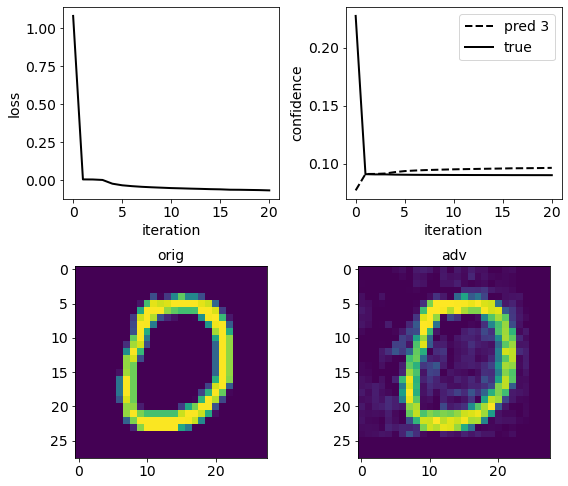

In [7]:
from secml.figure import CFigure
from secml.ml.classifiers.loss import CSoftmax


def plot_loss_img(attack, clf, sample_idx):
    n_iter = attack.x_seq.shape[0]
    itrs = CArray.arange(n_iter)
    true_class = ts_set.Y[sample_idx]
    fig = CFigure(width=8, height=7, fontsize=14, linewidth=2)

    fig.subplot(2, 2, 1)
    loss = attack.f_seq
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('loss')
    fig.sp.plot(itrs, loss, c='black')
    pred_classes, scores = clf.predict(attack.x_seq,
                                       return_decision_function=True)
    scores = CSoftmax().softmax(scores)

    fig.subplot(2, 2, 2)
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('confidence')
    fig.sp.plot(itrs, scores[:, pred_classes[-1].item()], linestyle='--',
                c='black', label='pred {:}'.format(pred_classes[-1].item()))
    fig.sp.plot(itrs, scores[:, true_class], c='black', label='true')
    fig.sp.legend()

    fig.subplot(2, 2, 3)
    fig.sp.title('orig')
    fig.sp.imshow(ts_set.X[sample_idx, :].tondarray().reshape((28, 28)))

    fig.subplot(2, 2, 4)
    fig.sp.title('adv')
    fig.sp.imshow(attack.x_seq[-1, :].tondarray().reshape((28, 28)))

    fig.tight_layout()
    fig.show()

# Only required for visualization in notebooks
%matplotlib inline
plot_loss_img(pgd_exp, dnr, sample_idx)